In [9]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
import cv2

In [3]:

print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Num GPUs Available:  2


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
# Set the path to your dataset
#base_dir = '../output/approach-2/'
#base_dir = '../output/0_1/'
#base_dir = '../output/0_2/'
#base_dir = '../output/1_2/'
base_dirs = ['../output/0_1/', '../output/0_2/', '../output/1_2/']

In [5]:
# Create a generator for reading images from the dataset
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
data = {}

In [8]:
# Flow images from the dataset, splitting them into training and validation sets
for bd in base_dirs:
    train_generator = datagen.flow_from_directory(
        bd,  
        target_size=(224, 224),  
        batch_size=64,
        class_mode='categorical',  
        color_mode='grayscale',  
        subset='training'  
    )

    val_generator = datagen.flow_from_directory(
        bd,  
        target_size=(224, 224),  
        batch_size=64,
        class_mode='categorical',  
        color_mode='grayscale',  
        subset='validation'  
    )
    key = bd.split('/')[-2]
    data[key] = (train_generator, val_generator)

Found 2288 images belonging to 2 classes.
Found 571 images belonging to 2 classes.
Found 2576 images belonging to 2 classes.
Found 643 images belonging to 2 classes.
Found 2670 images belonging to 2 classes.
Found 666 images belonging to 2 classes.


In [35]:
list(data.keys())

['0_1', '0_2', '1_2']

In [7]:
from tensorflow.keras import regularizers

In [10]:
def create_model():
    # Create a CNN model
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 1), kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(MaxPooling2D((2, 2)))
    #model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    #model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    #model.add(Dropout(0.5))
    #model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(2, activation='softmax'))  # 3 classes (0, 1, 2)
    return model

In [11]:
model = create_model()
#model.summary()

In [7]:
from keras.utils import plot_model, model_to_dot

# Assuming 'model' is your neural network model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# Assuming 'model' is your neural network model
dot = model_to_dot(model, show_shapes=True, show_layer_names=True)

# Save the DOT file
with open("sequential_model.dot", "w") as dot_file:
    dot_file.write(dot.to_string())

In [12]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam

In [13]:
# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
histories = {}
for k,v in data.items():
    # Train the model
    print('comparing ', k)
    train_generator = v[0]
    val_generator = v[1]
    model = create_model()
    model.compile(optimizer=Adagrad(learning_rate=0.1), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.n // train_generator.batch_size,
        epochs=15,
        validation_data=val_generator,
        validation_steps=val_generator.n // val_generator.batch_size  
    )
    histories[k] = (model,history)

comparing  0_1
Epoch 1/15
71/71 [==============================] - 38s 489ms/step - loss: 2.0679 - accuracy: 0.5550 - val_loss: 13.7483 - val_accuracy: 0.4779
Epoch 2/15
71/71 [==============================] - 6s 88ms/step - loss: 0.7920 - accuracy: 0.6884 - val_loss: 36.4450 - val_accuracy: 0.4835
Epoch 3/15
71/71 [==============================] - 6s 89ms/step - loss: 0.6777 - accuracy: 0.7110 - val_loss: 44.7863 - val_accuracy: 0.4926
Epoch 4/15
71/71 [==============================] - 6s 87ms/step - loss: 0.5582 - accuracy: 0.7482 - val_loss: 48.4957 - val_accuracy: 0.4798
Epoch 5/15
71/71 [==============================] - 6s 87ms/step - loss: 0.5090 - accuracy: 0.8094 - val_loss: 53.1211 - val_accuracy: 0.4779
Epoch 6/15
71/71 [==============================] - 6s 85ms/step - loss: 0.4551 - accuracy: 0.8626 - val_loss: 40.2887 - val_accuracy: 0.4779
Epoch 7/15
71/71 [==============================] - 7s 92ms/step - loss: 0.4835 - accuracy: 0.8834 - val_loss: 84.6096 - val_accura

In [40]:
history

In [15]:
def showDetails(history, k):
    c = k.split('_')
    plt.figure(figsize=(8, 6))
    #plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.ylim([0,1.2])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'Class {c[0]} and Class {c[1]}')

    plt.figure(figsize=(8, 6))
    #plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    #plt.ylim([0.0,1])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Class {c[0]} and Class {c[1]}')

    plt.show()

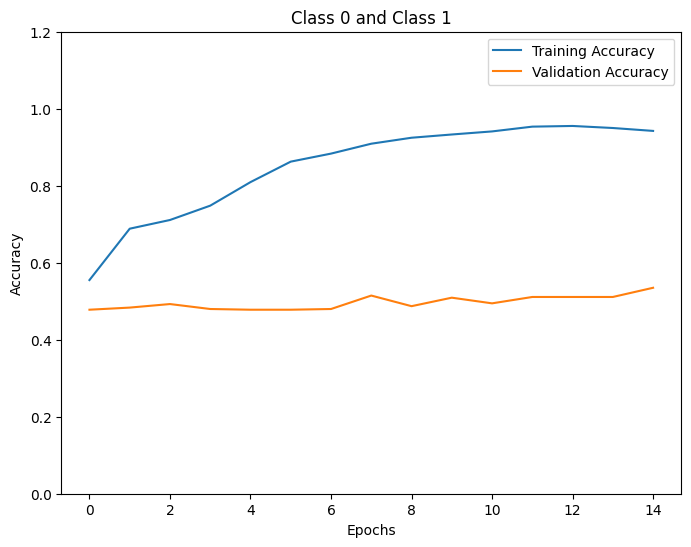

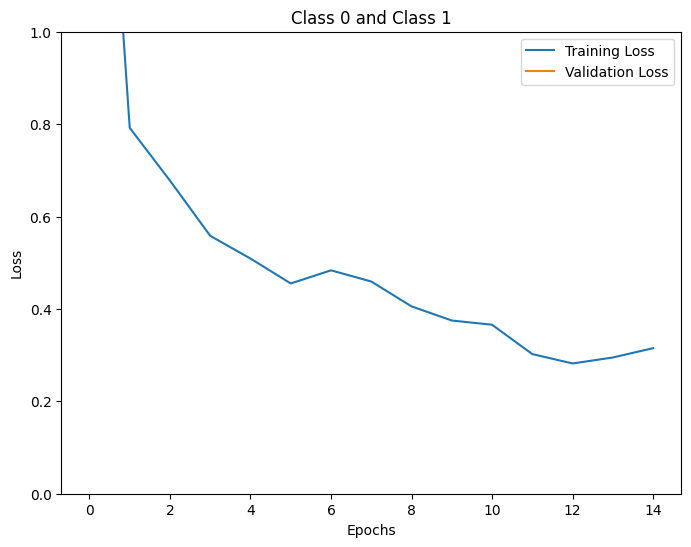

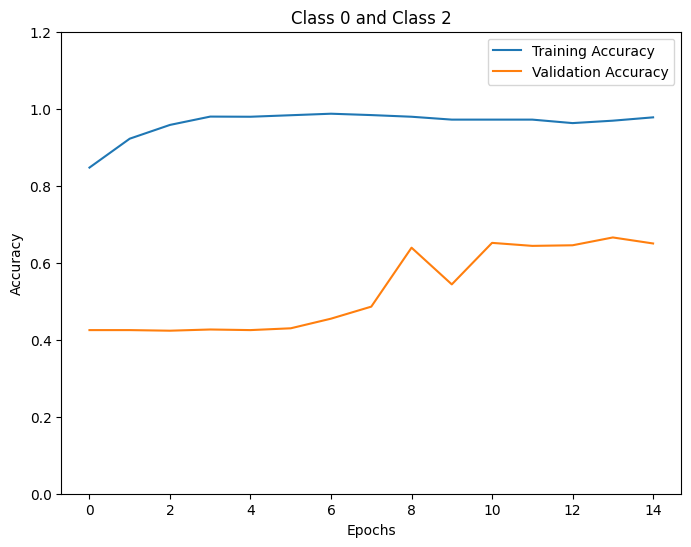

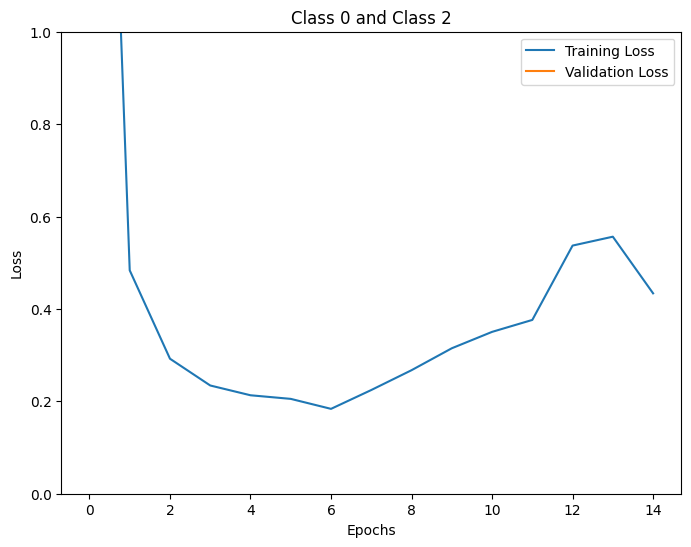

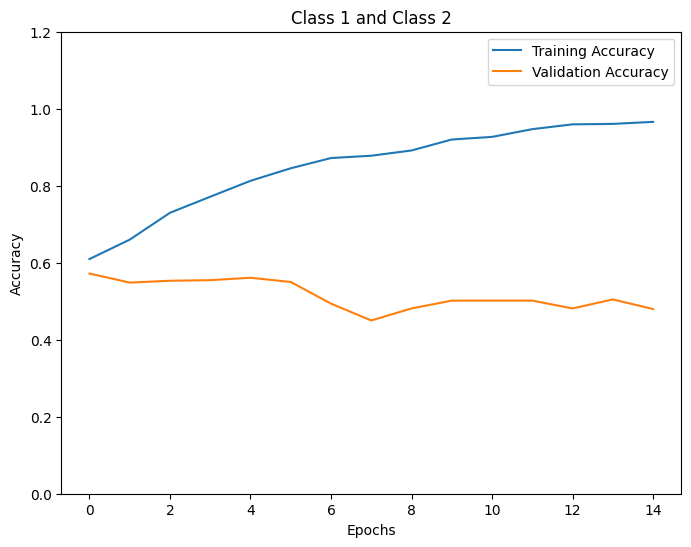

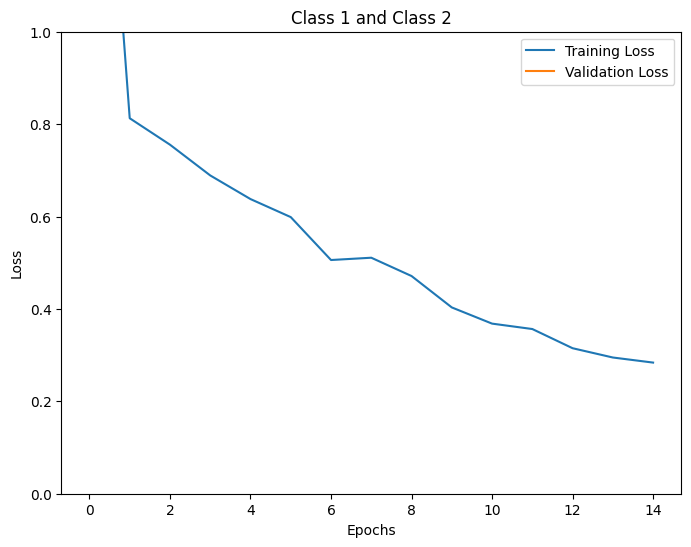

In [16]:
for k,v in histories.items():
    showDetails(v[1], k)

In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

0_1
18/18 [==============================] - 1s 69ms/step


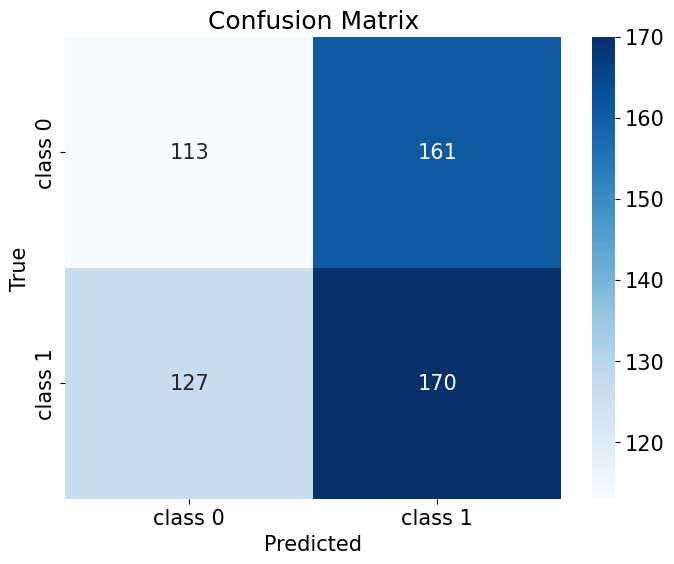

              precision    recall  f1-score   support

     class 0       0.47      0.41      0.44       274
     class 1       0.51      0.57      0.54       297

    accuracy                           0.50       571
   macro avg       0.49      0.49      0.49       571
weighted avg       0.49      0.50      0.49       571

0_2
21/21 [==============================] - 2s 76ms/step


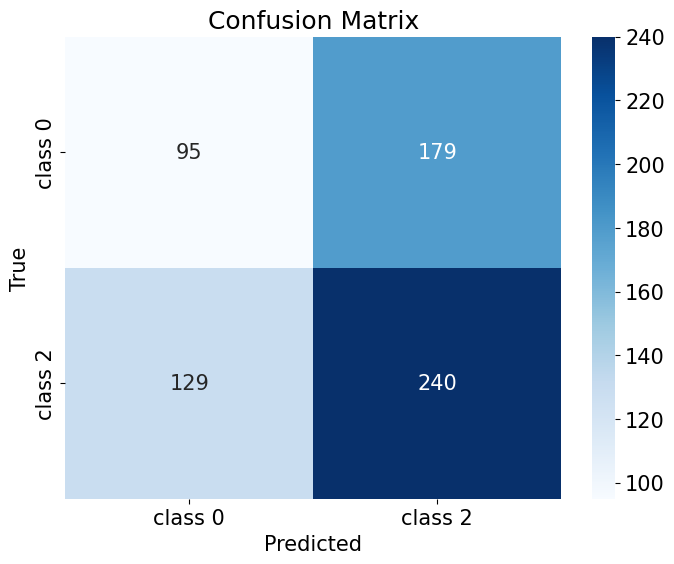

              precision    recall  f1-score   support

     class 0       0.42      0.35      0.38       274
     class 2       0.57      0.65      0.61       369

    accuracy                           0.52       643
   macro avg       0.50      0.50      0.50       643
weighted avg       0.51      0.52      0.51       643

1_2
21/21 [==============================] - 2s 68ms/step


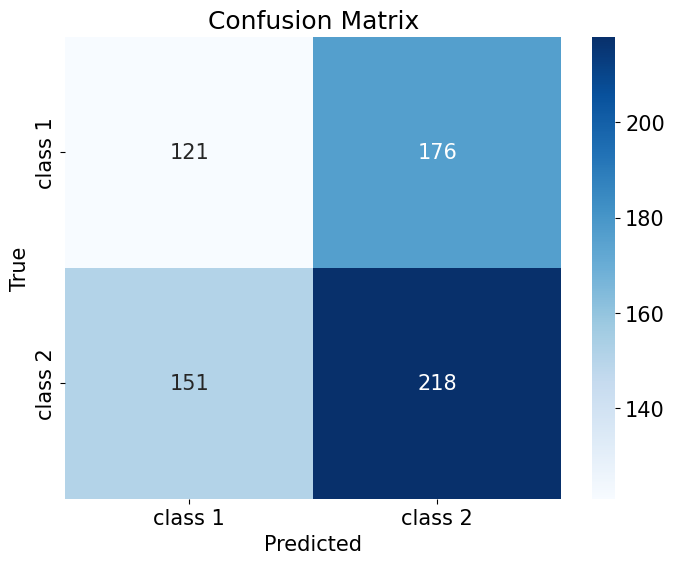

              precision    recall  f1-score   support

     class 1       0.44      0.41      0.43       297
     class 2       0.55      0.59      0.57       369

    accuracy                           0.51       666
   macro avg       0.50      0.50      0.50       666
weighted avg       0.50      0.51      0.51       666



In [181]:

for k, v in data.items():
    c = k.split('_')
    labels = {0: f'class {c[0]}', 1: f'class {c[1]}'}
    # Get predictions
    print(k)
    model = histories[k][0]
    val_generator = v[1]
    Y_pred = model.predict(val_generator)
    y_pred = np.argmax(Y_pred, axis=1)

    y_true = val_generator.classes

    # Plot confusion matrix with numerical values
    conf_mat = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels.values(), yticklabels=labels.values())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=labels.values()))

In [ ]:
# Get predictions
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Convert labels back to original encoding
# labels = {0: 'Low', 1: 'Average', 2: 'High'}
labels = {0: 'Low', 1: 'High'}
validation_labels = [labels[k] for k in val_generator.classes]
y_true = val_generator.classes

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(conf_mat, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(labels)), labels.values(), rotation=45)
plt.yticks(np.arange(len(labels)), labels.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [58]:
# Get predictions
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

20/20 [==============================] - 2s 76ms/step


In [ ]:
# Convert labels back to original encoding
# labels = {0: 'Low', 1: 'Average', 2: 'High'}
labels = {0: 'Low', 1: 'High'}
#validation_labels = [labels[k] for k in val_generator.classes]
validation_labels = val_generator.classes
#print(y_pred)
y_true = val_generator.classes
#print(y_true)

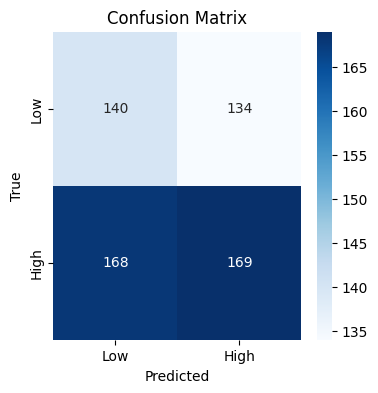

              precision    recall  f1-score   support

         Low       0.45      0.51      0.48       274
        High       0.56      0.50      0.53       337

    accuracy                           0.51       611
   macro avg       0.51      0.51      0.50       611
weighted avg       0.51      0.51      0.51       611



In [64]:


# Plot confusion matrix with numerical values
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels.values(), yticklabels=labels.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=labels.values()))

20/20 [==============================] - 2s 82ms/step


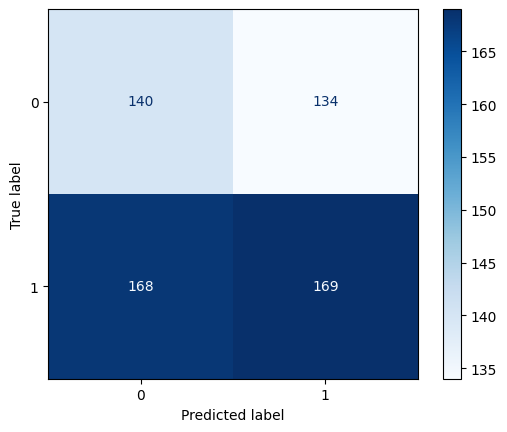

In [60]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming y_true and y_pred are your true and predicted labels
# Get true labels
y_true = val_generator.classes

# Get predicted probabilities
Y_pred = model.predict(val_generator)

# Get predicted class indices
y_pred = np.argmax(Y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap='Blues', values_format='d')
plt.show()

In [58]:
base_dir = '../output/approach-2/'

In [90]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [117]:
train_generator = datagen.flow_from_directory(
    base_dir,  
    target_size=(64, 64),  
    batch_size=64,
    class_mode='categorical',  
    color_mode='grayscale',  
    subset='training'  
)

val_generator = datagen.flow_from_directory(
    base_dir,  
    target_size=(64, 64),  
    batch_size=64,
    class_mode='categorical',  
    color_mode='grayscale',  
    subset='validation'  
)

Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.


In [118]:
#{'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 16, 'epochs': 20, 'optimizer': 'adagrad'}
def create_model_3():
    # Create a CNN model
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 1))) #, kernel_regularizer=regularizers.l2(0.001)
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(16, (3, 3), activation='relu')) # , kernel_regularizer=regularizers.l2(0.001)
    model.add(MaxPooling2D((2, 2)))
    #model.add(Conv2D(64, (3, 3), activation='relu'))
    #model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    #model.add(Dropout(0.5))
    #model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(3, activation='softmax'))  # 3 classes (0, 1, 2)
    return model

## Manual model Optuna

In [80]:
import optuna

In [76]:
def create_optuna_model(num_filters, num_layers,batch_norm, drop_out=0):
    model = Sequential()
    for _ in range(num_layers):
        model.add(Conv2D(num_filters, (3, 3), activation='relu', input_shape=(64, 64, 1))) #, kernel_regularizer=regularizers.l2(0.001)
        if batch_norm:
            model.add(BatchNormalization(0))
        if drop_out > 0:
            model.add(Dropout(drop_out))
        model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(num_filters, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    #model.add(Dropout(0.5))
    #model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(3, activation='softmax'))  # 3 classes (0, 1, 2)
    return model

In [77]:
def get_optimizer(name, learning_rate):
    if name == 'adam':
        return Adam(learning_rate=learning_rate)
    elif name == 'sgd':
        return SGD(learning_rate=learning_rate)
    elif name == 'rmsprop':
        return RMSprop(learning_rate=learning_rate)
    elif name == 'adagrad':
        return Adagrad(learning_rate=learning_rate)
    elif name == 'adadelta':
        return Adadelta(learning_rate=learning_rate)
    elif name == 'adamax':
        return Adamax(learning_rate=learning_rate)
    elif name == 'nadam':
        return Nadam(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {name}")

In [78]:
def objective(trial):

    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.1])
    num_filters = trial.suggest_categorical('num_filters', [16, 32])
    num_layers = trial.suggest_int('num_layers', 1, 2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    epochs = trial.suggest_categorical('epochs', [10, 15, 20])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam'])
    batch_norm = trial.suggest_categorical('batch_norm', [True, False])
    drop_out = trial.suggest_categorical('drop_out', [0.1, 0.2, 0.3])


    model = create_optuna_model(num_filters, num_layers, batch_norm, drop_out)

    optimizer = get_optimizer(optimizer_name, learning_rate)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Split the data into training and validation sets
    train_generator = datagen.flow_from_directory(
        base_dir,  
        target_size=(64, 64),  
        batch_size=batch_size,
        class_mode='categorical',  
        color_mode='grayscale',  
        subset='training'  
    )

    val_generator = datagen.flow_from_directory(
        base_dir,  
        target_size=(64, 64),  
        batch_size=batch_size,
        class_mode='categorical',  
        color_mode='grayscale',  
        subset='validation'  
    )

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.n // train_generator.batch_size,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=val_generator.n // val_generator.batch_size,
        verbose=1
    )

    # Return the validation accuracy for Optuna to optimize
    return history.history['val_accuracy'][-1]

In [81]:
# with more hyper parameter
# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Print the best parameters found by Optuna
print('Best trial:')
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2024-01-17 09:11:14,270] A new study created in memory with name: no-name-d85c7121-6d36-4920-9bad-24f5bff2c706


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/15
58/58 [==============================] - 9s 140ms/step - loss: 1.2094 - accuracy: 0.3787 - val_loss: 1.1442 - val_accuracy: 0.2913
Epoch 2/15
58/58 [==============================] - 8s 136ms/step - loss: 1.0582 - accuracy: 0.4282 - val_loss: 1.1148 - val_accuracy: 0.3683
Epoch 3/15
58/58 [==============================] - 8s 137ms/step - loss: 0.9870 - accuracy: 0.4791 - val_loss: 1.1418 - val_accuracy: 0.3750
Epoch 4/15
58/58 [==============================] - 8s 134ms/step - loss: 0.8988 - accuracy: 0.6316 - val_loss: 1.0362 - val_accuracy: 0.4799
Epoch 5/15
58/58 [==============================] - 8s 139ms/step - loss: 0.8044 - accuracy: 0.6652 - val_loss: 1.0358 - val_accuracy: 0.4978
Epoch 6/15
58/58 [==============================] - 8s 134ms/step - loss: 0.7151 - accuracy: 0.7132 - val_loss: 1.0362 - val_accuracy: 0.5089
Epoch 7/15
58/58 [==============================] - 8s 132ms/step

[I 2024-01-17 09:13:14,702] Trial 0 finished with value: 0.4977678656578064 and parameters: {'learning_rate': 0.001, 'num_filters': 32, 'num_layers': 1, 'batch_size': 64, 'epochs': 15, 'optimizer': 'nadam'}. Best is trial 0 with value: 0.4977678656578064.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/10
234/234 [==============================] - 12s 47ms/step - loss: 0.9026 - accuracy: 0.5652 - val_loss: 1.0710 - val_accuracy: 0.4591
Epoch 2/10
234/234 [==============================] - 10s 44ms/step - loss: 0.7365 - accuracy: 0.6853 - val_loss: 1.1247 - val_accuracy: 0.4386
Epoch 3/10
234/234 [==============================] - 11s 48ms/step - loss: 0.6840 - accuracy: 0.7283 - val_loss: 1.1123 - val_accuracy: 0.4731
Epoch 4/10
234/234 [==============================] - 11s 47ms/step - loss: 0.6463 - accuracy: 0.7545 - val_loss: 1.0913 - val_accuracy: 0.4914
Epoch 5/10
234/234 [==============================] - 11s 46ms/step - loss: 0.6049 - accuracy: 0.7810 - val_loss: 1.1742 - val_accuracy: 0.4591
Epoch 6/10
234/234 [==============================] - 11s 46ms/step - loss: 0.5752 - accuracy: 0.8070 - val_loss: 1.1822 - val_accuracy: 0.4914
Epoch 7/10
234/234 [==============================] -

[I 2024-01-17 09:15:04,598] Trial 1 finished with value: 0.45150861144065857 and parameters: {'learning_rate': 0.01, 'num_filters': 16, 'num_layers': 1, 'batch_size': 16, 'epochs': 10, 'optimizer': 'nadam'}. Best is trial 0 with value: 0.4977678656578064.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/15
117/117 [==============================] - 10s 83ms/step - loss: 0.8910 - accuracy: 0.5870 - val_loss: 1.0529 - val_accuracy: 0.4784
Epoch 2/15
117/117 [==============================] - 9s 78ms/step - loss: 0.7283 - accuracy: 0.7057 - val_loss: 1.0923 - val_accuracy: 0.4720
Epoch 3/15
117/117 [==============================] - 9s 76ms/step - loss: 0.6878 - accuracy: 0.7425 - val_loss: 1.1347 - val_accuracy: 0.4871
Epoch 4/15
117/117 [==============================] - 9s 80ms/step - loss: 0.6552 - accuracy: 0.7602 - val_loss: 1.1091 - val_accuracy: 0.4925
Epoch 5/15
117/117 [==============================] - 9s 78ms/step - loss: 0.6169 - accuracy: 0.7860 - val_loss: 1.1328 - val_accuracy: 0.4978
Epoch 6/15
117/117 [==============================] - 9s 74ms/step - loss: 0.5975 - accuracy: 0.8013 - val_loss: 1.1556 - val_accuracy: 0.4763
Epoch 7/15
117/117 [==============================] - 9s 7

[I 2024-01-17 09:17:24,788] Trial 2 finished with value: 0.45366379618644714 and parameters: {'learning_rate': 0.1, 'num_filters': 32, 'num_layers': 1, 'batch_size': 32, 'epochs': 15, 'optimizer': 'adagrad'}. Best is trial 0 with value: 0.4977678656578064.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/20
58/58 [==============================] - 9s 141ms/step - loss: 0.9554 - accuracy: 0.5328 - val_loss: 0.9910 - val_accuracy: 0.5022
Epoch 2/20
58/58 [==============================] - 8s 142ms/step - loss: 0.7459 - accuracy: 0.6598 - val_loss: 0.9674 - val_accuracy: 0.5357
Epoch 3/20
58/58 [==============================] - 8s 143ms/step - loss: 0.6970 - accuracy: 0.6782 - val_loss: 1.1318 - val_accuracy: 0.4922
Epoch 4/20
58/58 [==============================] - 8s 135ms/step - loss: 0.6881 - accuracy: 0.6885 - val_loss: 1.0051 - val_accuracy: 0.5435
Epoch 5/20
58/58 [==============================] - 8s 140ms/step - loss: 0.6504 - accuracy: 0.7167 - val_loss: 1.0165 - val_accuracy: 0.4911
Epoch 6/20
58/58 [==============================] - 8s 142ms/step - loss: 0.6413 - accuracy: 0.7194 - val_loss: 1.0342 - val_accuracy: 0.5167
Epoch 7/20
58/58 [==============================] - 8s 141ms/step

[I 2024-01-17 09:20:13,168] Trial 3 finished with value: 0.5044642686843872 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 64, 'epochs': 20, 'optimizer': 'adagrad'}. Best is trial 3 with value: 0.5044642686843872.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/20
117/117 [==============================] - 10s 82ms/step - loss: 0.9805 - accuracy: 0.5440 - val_loss: 1.0093 - val_accuracy: 0.4892
Epoch 2/20
117/117 [==============================] - 9s 79ms/step - loss: 0.7800 - accuracy: 0.6576 - val_loss: 1.0093 - val_accuracy: 0.5000
Epoch 3/20
117/117 [==============================] - 9s 80ms/step - loss: 0.7243 - accuracy: 0.6971 - val_loss: 1.1577 - val_accuracy: 0.4192
Epoch 4/20
117/117 [==============================] - 9s 79ms/step - loss: 0.6817 - accuracy: 0.7242 - val_loss: 1.0473 - val_accuracy: 0.5140
Epoch 5/20
117/117 [==============================] - 9s 80ms/step - loss: 0.6545 - accuracy: 0.7540 - val_loss: 1.0357 - val_accuracy: 0.5248
Epoch 6/20
117/117 [==============================] - 10s 84ms/step - loss: 0.6325 - accuracy: 0.7605 - val_loss: 1.0920 - val_accuracy: 0.4892
Epoch 7/20
117/117 [==============================] - 9s 

[I 2024-01-17 09:23:25,376] Trial 4 finished with value: 0.48491379618644714 and parameters: {'learning_rate': 0.01, 'num_filters': 32, 'num_layers': 1, 'batch_size': 32, 'epochs': 20, 'optimizer': 'rmsprop'}. Best is trial 3 with value: 0.5044642686843872.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/20
234/234 [==============================] - 11s 43ms/step - loss: 0.8667 - accuracy: 0.5492 - val_loss: 0.9849 - val_accuracy: 0.5248
Epoch 2/20
234/234 [==============================] - 11s 47ms/step - loss: 0.7107 - accuracy: 0.6933 - val_loss: 1.0245 - val_accuracy: 0.5097
Epoch 3/20
234/234 [==============================] - 11s 46ms/step - loss: 0.6598 - accuracy: 0.7393 - val_loss: 1.0430 - val_accuracy: 0.5323
Epoch 4/20
234/234 [==============================] - 11s 48ms/step - loss: 0.6263 - accuracy: 0.7652 - val_loss: 1.0729 - val_accuracy: 0.4925
Epoch 5/20
234/234 [==============================] - 11s 47ms/step - loss: 0.5888 - accuracy: 0.7888 - val_loss: 1.1596 - val_accuracy: 0.4591
Epoch 6/20
234/234 [==============================] - 11s 46ms/step - loss: 0.5518 - accuracy: 0.8067 - val_loss: 1.1823 - val_accuracy: 0.4440
Epoch 7/20
234/234 [==============================] -

[I 2024-01-17 09:27:11,701] Trial 5 finished with value: 0.48168104887008667 and parameters: {'learning_rate': 0.01, 'num_filters': 16, 'num_layers': 1, 'batch_size': 16, 'epochs': 20, 'optimizer': 'adam'}. Best is trial 3 with value: 0.5044642686843872.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/10
117/117 [==============================] - 10s 79ms/step - loss: 0.9034 - accuracy: 0.5255 - val_loss: 1.1231 - val_accuracy: 0.4741
Epoch 2/10
117/117 [==============================] - 9s 77ms/step - loss: 0.7175 - accuracy: 0.6772 - val_loss: 1.0920 - val_accuracy: 0.4601
Epoch 3/10
117/117 [==============================] - 9s 80ms/step - loss: 0.6649 - accuracy: 0.7137 - val_loss: 1.0777 - val_accuracy: 0.4784
Epoch 4/10
117/117 [==============================] - 10s 83ms/step - loss: 0.6295 - accuracy: 0.7293 - val_loss: 1.1157 - val_accuracy: 0.4709
Epoch 5/10
117/117 [==============================] - 9s 80ms/step - loss: 0.6133 - accuracy: 0.7376 - val_loss: 1.1742 - val_accuracy: 0.4677
Epoch 6/10
117/117 [==============================] - 10s 81ms/step - loss: 0.5803 - accuracy: 0.7650 - val_loss: 1.1769 - val_accuracy: 0.4763
Epoch 7/10
117/117 [==============================] - 9s

[I 2024-01-17 09:28:49,330] Trial 6 finished with value: 0.4806034564971924 and parameters: {'learning_rate': 0.1, 'num_filters': 32, 'num_layers': 2, 'batch_size': 32, 'epochs': 10, 'optimizer': 'adadelta'}. Best is trial 3 with value: 0.5044642686843872.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/15
58/58 [==============================] - 9s 145ms/step - loss: 1.0217 - accuracy: 0.4843 - val_loss: 1.0127 - val_accuracy: 0.4978
Epoch 2/15
58/58 [==============================] - 8s 142ms/step - loss: 0.8206 - accuracy: 0.6219 - val_loss: 0.9810 - val_accuracy: 0.4989
Epoch 3/15
58/58 [==============================] - 8s 138ms/step - loss: 0.7585 - accuracy: 0.6674 - val_loss: 1.0343 - val_accuracy: 0.4877
Epoch 4/15
58/58 [==============================] - 8s 141ms/step - loss: 0.7374 - accuracy: 0.6769 - val_loss: 1.0273 - val_accuracy: 0.5022
Epoch 5/15
58/58 [==============================] - 8s 141ms/step - loss: 0.6973 - accuracy: 0.7216 - val_loss: 1.0385 - val_accuracy: 0.4855
Epoch 6/15
58/58 [==============================] - 7s 126ms/step - loss: 0.6860 - accuracy: 0.7262 - val_loss: 1.0654 - val_accuracy: 0.4788
Epoch 7/15
58/58 [==============================] - 8s 140ms/step

[I 2024-01-17 09:30:54,553] Trial 7 finished with value: 0.4944196343421936 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 1, 'batch_size': 64, 'epochs': 15, 'optimizer': 'adadelta'}. Best is trial 3 with value: 0.5044642686843872.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/15
117/117 [==============================] - 10s 85ms/step - loss: 0.9070 - accuracy: 0.5416 - val_loss: 0.9787 - val_accuracy: 0.4935
Epoch 2/15
117/117 [==============================] - 9s 80ms/step - loss: 0.7522 - accuracy: 0.6450 - val_loss: 1.0023 - val_accuracy: 0.5065
Epoch 3/15
117/117 [==============================] - 9s 79ms/step - loss: 0.7088 - accuracy: 0.6740 - val_loss: 1.0152 - val_accuracy: 0.5216
Epoch 4/15
117/117 [==============================] - 10s 84ms/step - loss: 0.6604 - accuracy: 0.7336 - val_loss: 1.0343 - val_accuracy: 0.5108
Epoch 5/15
117/117 [==============================] - 9s 76ms/step - loss: 0.6397 - accuracy: 0.7575 - val_loss: 1.0747 - val_accuracy: 0.5129
Epoch 6/15
117/117 [==============================] - 10s 83ms/step - loss: 0.6095 - accuracy: 0.7833 - val_loss: 1.1081 - val_accuracy: 0.4784
Epoch 7/15
117/117 [==============================] - 10

[I 2024-01-17 09:33:19,652] Trial 8 finished with value: 0.4450431168079376 and parameters: {'learning_rate': 0.1, 'num_filters': 16, 'num_layers': 1, 'batch_size': 32, 'epochs': 15, 'optimizer': 'adam'}. Best is trial 3 with value: 0.5044642686843872.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/20
117/117 [==============================] - 10s 80ms/step - loss: 1.0669 - accuracy: 0.4970 - val_loss: 1.0840 - val_accuracy: 0.4720
Epoch 2/20
117/117 [==============================] - 9s 81ms/step - loss: 0.8897 - accuracy: 0.5808 - val_loss: 1.0689 - val_accuracy: 0.4698
Epoch 3/20
117/117 [==============================] - 10s 82ms/step - loss: 0.7963 - accuracy: 0.6369 - val_loss: 1.0828 - val_accuracy: 0.4677
Epoch 4/20
117/117 [==============================] - 9s 79ms/step - loss: 0.7651 - accuracy: 0.6678 - val_loss: 1.0944 - val_accuracy: 0.4677
Epoch 5/20
117/117 [==============================] - 10s 83ms/step - loss: 0.7390 - accuracy: 0.6821 - val_loss: 1.0204 - val_accuracy: 0.5097
Epoch 6/20
117/117 [==============================] - 9s 77ms/step - loss: 0.7210 - accuracy: 0.6987 - val_loss: 1.0906 - val_accuracy: 0.4871
Epoch 7/20
117/117 [==============================] - 9s

[I 2024-01-17 09:36:32,253] Trial 9 finished with value: 0.46443966031074524 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 1, 'batch_size': 32, 'epochs': 20, 'optimizer': 'adam'}. Best is trial 3 with value: 0.5044642686843872.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/20
58/58 [==============================] - 9s 142ms/step - loss: 0.9073 - accuracy: 0.5553 - val_loss: 1.0097 - val_accuracy: 0.4855
Epoch 2/20
58/58 [==============================] - 8s 141ms/step - loss: 0.7118 - accuracy: 0.6788 - val_loss: 1.0468 - val_accuracy: 0.4643
Epoch 3/20
58/58 [==============================] - 8s 141ms/step - loss: 0.6617 - accuracy: 0.7026 - val_loss: 1.0802 - val_accuracy: 0.4643
Epoch 4/20
58/58 [==============================] - 8s 138ms/step - loss: 0.6380 - accuracy: 0.7132 - val_loss: 1.0971 - val_accuracy: 0.4743
Epoch 5/20
58/58 [==============================] - 8s 136ms/step - loss: 0.6181 - accuracy: 0.7259 - val_loss: 1.1386 - val_accuracy: 0.4576
Epoch 6/20
58/58 [==============================] - 8s 140ms/step - loss: 0.6068 - accuracy: 0.7394 - val_loss: 1.1455 - val_accuracy: 0.4453
Epoch 7/20
58/58 [==============================] - 8s 136ms/step

[I 2024-01-17 09:39:15,372] Trial 10 finished with value: 0.4631696343421936 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 64, 'epochs': 20, 'optimizer': 'adagrad'}. Best is trial 3 with value: 0.5044642686843872.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/15
58/58 [==============================] - 9s 140ms/step - loss: 0.9667 - accuracy: 0.4707 - val_loss: 1.0379 - val_accuracy: 0.4263
Epoch 2/15
58/58 [==============================] - 8s 137ms/step - loss: 0.7887 - accuracy: 0.5907 - val_loss: 1.0732 - val_accuracy: 0.5000
Epoch 3/15
58/58 [==============================] - 8s 136ms/step - loss: 0.7182 - accuracy: 0.6828 - val_loss: 1.0486 - val_accuracy: 0.5123
Epoch 4/15
58/58 [==============================] - 8s 135ms/step - loss: 0.6885 - accuracy: 0.7048 - val_loss: 1.0682 - val_accuracy: 0.4922
Epoch 5/15
58/58 [==============================] - 8s 137ms/step - loss: 0.6477 - accuracy: 0.7251 - val_loss: 1.0883 - val_accuracy: 0.4944
Epoch 6/15
58/58 [==============================] - 8s 135ms/step - loss: 0.6177 - accuracy: 0.7340 - val_loss: 1.1327 - val_accuracy: 0.4699
Epoch 7/15
58/58 [==============================] - 8s 137ms/step

[I 2024-01-17 09:41:18,365] Trial 11 finished with value: 0.4620535671710968 and parameters: {'learning_rate': 0.001, 'num_filters': 32, 'num_layers': 2, 'batch_size': 64, 'epochs': 15, 'optimizer': 'nadam'}. Best is trial 3 with value: 0.5044642686843872.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/20
58/58 [==============================] - 8s 125ms/step - loss: 0.9460 - accuracy: 0.5154 - val_loss: 1.0496 - val_accuracy: 0.4788
Epoch 2/20
58/58 [==============================] - 8s 134ms/step - loss: 0.7411 - accuracy: 0.6658 - val_loss: 1.0227 - val_accuracy: 0.4844
Epoch 3/20
58/58 [==============================] - 8s 137ms/step - loss: 0.6939 - accuracy: 0.6904 - val_loss: 1.0555 - val_accuracy: 0.4810
Epoch 4/20
58/58 [==============================] - 8s 135ms/step - loss: 0.6414 - accuracy: 0.7175 - val_loss: 1.0782 - val_accuracy: 0.4844
Epoch 5/20
58/58 [==============================] - 8s 136ms/step - loss: 0.6161 - accuracy: 0.7319 - val_loss: 1.1511 - val_accuracy: 0.4721
Epoch 6/20
58/58 [==============================] - 8s 136ms/step - loss: 0.5966 - accuracy: 0.7465 - val_loss: 1.1939 - val_accuracy: 0.4643
Epoch 7/20
58/58 [==============================] - 8s 133ms/step

[I 2024-01-17 09:43:59,955] Trial 12 finished with value: 0.4854910671710968 and parameters: {'learning_rate': 0.001, 'num_filters': 32, 'num_layers': 2, 'batch_size': 64, 'epochs': 20, 'optimizer': 'adamax'}. Best is trial 3 with value: 0.5044642686843872.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/15
58/58 [==============================] - 9s 141ms/step - loss: 0.8845 - accuracy: 0.5710 - val_loss: 1.0270 - val_accuracy: 0.5123
Epoch 2/15
58/58 [==============================] - 8s 138ms/step - loss: 0.7432 - accuracy: 0.6674 - val_loss: 1.0303 - val_accuracy: 0.5324
Epoch 3/15
58/58 [==============================] - 8s 130ms/step - loss: 0.6925 - accuracy: 0.6961 - val_loss: 1.1033 - val_accuracy: 0.5179
Epoch 4/15
58/58 [==============================] - 8s 134ms/step - loss: 0.6559 - accuracy: 0.7124 - val_loss: 1.0937 - val_accuracy: 0.4866
Epoch 5/15
58/58 [==============================] - 8s 137ms/step - loss: 0.6312 - accuracy: 0.7308 - val_loss: 1.1085 - val_accuracy: 0.4721
Epoch 6/15
58/58 [==============================] - 8s 136ms/step - loss: 0.6100 - accuracy: 0.7362 - val_loss: 1.1818 - val_accuracy: 0.4576
Epoch 7/15
58/58 [==============================] - 8s 137ms/step

[I 2024-01-17 09:46:01,282] Trial 13 finished with value: 0.4966517984867096 and parameters: {'learning_rate': 0.001, 'num_filters': 32, 'num_layers': 2, 'batch_size': 64, 'epochs': 15, 'optimizer': 'sgd'}. Best is trial 3 with value: 0.5044642686843872.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/10
58/58 [==============================] - 9s 140ms/step - loss: 0.9644 - accuracy: 0.5295 - val_loss: 1.0290 - val_accuracy: 0.4933
Epoch 2/10
58/58 [==============================] - 8s 136ms/step - loss: 0.7711 - accuracy: 0.6501 - val_loss: 1.0118 - val_accuracy: 0.5156
Epoch 3/10
58/58 [==============================] - 8s 133ms/step - loss: 0.7326 - accuracy: 0.6641 - val_loss: 1.0458 - val_accuracy: 0.5078
Epoch 4/10
58/58 [==============================] - 8s 139ms/step - loss: 0.6881 - accuracy: 0.6950 - val_loss: 1.0567 - val_accuracy: 0.5045
Epoch 5/10
58/58 [==============================] - 8s 137ms/step - loss: 0.6729 - accuracy: 0.7107 - val_loss: 1.0632 - val_accuracy: 0.4911
Epoch 6/10
58/58 [==============================] - 8s 136ms/step - loss: 0.6499 - accuracy: 0.7202 - val_loss: 1.0937 - val_accuracy: 0.5156
Epoch 7/10
58/58 [==============================] - 8s 136ms/step

[I 2024-01-17 09:47:23,698] Trial 14 finished with value: 0.5100446343421936 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 64, 'epochs': 10, 'optimizer': 'nadam'}. Best is trial 14 with value: 0.5100446343421936.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/10
58/58 [==============================] - 9s 143ms/step - loss: 0.9312 - accuracy: 0.5336 - val_loss: 1.0189 - val_accuracy: 0.5100
Epoch 2/10
58/58 [==============================] - 8s 138ms/step - loss: 0.7575 - accuracy: 0.6376 - val_loss: 1.0093 - val_accuracy: 0.5134
Epoch 3/10
58/58 [==============================] - 8s 137ms/step - loss: 0.7013 - accuracy: 0.6801 - val_loss: 1.0039 - val_accuracy: 0.5190
Epoch 4/10
58/58 [==============================] - 8s 141ms/step - loss: 0.6599 - accuracy: 0.7072 - val_loss: 1.0541 - val_accuracy: 0.4821
Epoch 5/10
58/58 [==============================] - 8s 140ms/step - loss: 0.6430 - accuracy: 0.7118 - val_loss: 1.0372 - val_accuracy: 0.4833
Epoch 6/10
58/58 [==============================] - 8s 138ms/step - loss: 0.6203 - accuracy: 0.7254 - val_loss: 1.1115 - val_accuracy: 0.4721
Epoch 7/10
58/58 [==============================] - 8s 136ms/step

[I 2024-01-17 09:48:46,362] Trial 15 finished with value: 0.4430803656578064 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 64, 'epochs': 10, 'optimizer': 'adagrad'}. Best is trial 14 with value: 0.5100446343421936.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/10
58/58 [==============================] - 9s 143ms/step - loss: 0.9375 - accuracy: 0.5406 - val_loss: 0.9853 - val_accuracy: 0.5346
Epoch 2/10
58/58 [==============================] - 8s 136ms/step - loss: 0.7524 - accuracy: 0.6506 - val_loss: 1.0143 - val_accuracy: 0.5045
Epoch 3/10
58/58 [==============================] - 8s 136ms/step - loss: 0.6956 - accuracy: 0.6915 - val_loss: 1.0290 - val_accuracy: 0.5033
Epoch 4/10
58/58 [==============================] - 8s 139ms/step - loss: 0.6568 - accuracy: 0.7110 - val_loss: 1.0176 - val_accuracy: 0.5368
Epoch 5/10
58/58 [==============================] - 8s 135ms/step - loss: 0.6314 - accuracy: 0.7278 - val_loss: 1.0603 - val_accuracy: 0.5223
Epoch 6/10
58/58 [==============================] - 8s 136ms/step - loss: 0.6169 - accuracy: 0.7356 - val_loss: 1.0490 - val_accuracy: 0.5324
Epoch 7/10
58/58 [==============================] - 8s 134ms/step

[I 2024-01-17 09:50:08,322] Trial 16 finished with value: 0.4955357015132904 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 64, 'epochs': 10, 'optimizer': 'adamax'}. Best is trial 14 with value: 0.5100446343421936.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/10
234/234 [==============================] - 11s 46ms/step - loss: 0.8727 - accuracy: 0.5503 - val_loss: 0.9894 - val_accuracy: 0.5366
Epoch 2/10
234/234 [==============================] - 11s 48ms/step - loss: 0.7095 - accuracy: 0.6733 - val_loss: 1.0396 - val_accuracy: 0.4881
Epoch 3/10
234/234 [==============================] - 11s 45ms/step - loss: 0.6657 - accuracy: 0.6944 - val_loss: 1.0685 - val_accuracy: 0.4677
Epoch 4/10
234/234 [==============================] - 11s 45ms/step - loss: 0.6392 - accuracy: 0.7110 - val_loss: 1.1773 - val_accuracy: 0.4397
Epoch 5/10
234/234 [==============================] - 12s 49ms/step - loss: 0.6145 - accuracy: 0.7310 - val_loss: 1.1201 - val_accuracy: 0.4806
Epoch 6/10
234/234 [==============================] - 11s 47ms/step - loss: 0.5965 - accuracy: 0.7366 - val_loss: 1.1625 - val_accuracy: 0.4784
Epoch 7/10
234/234 [==============================] -

[I 2024-01-17 09:51:59,802] Trial 17 finished with value: 0.46336206793785095 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 16, 'epochs': 10, 'optimizer': 'sgd'}. Best is trial 14 with value: 0.5100446343421936.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/10
58/58 [==============================] - 9s 142ms/step - loss: 1.0055 - accuracy: 0.4594 - val_loss: 1.0177 - val_accuracy: 0.4788
Epoch 2/10
58/58 [==============================] - 8s 134ms/step - loss: 0.7686 - accuracy: 0.6498 - val_loss: 0.9866 - val_accuracy: 0.5067
Epoch 3/10
58/58 [==============================] - 8s 136ms/step - loss: 0.6902 - accuracy: 0.6874 - val_loss: 1.0595 - val_accuracy: 0.4922
Epoch 4/10
58/58 [==============================] - 8s 131ms/step - loss: 0.6506 - accuracy: 0.7010 - val_loss: 1.0989 - val_accuracy: 0.4688
Epoch 5/10
58/58 [==============================] - 8s 136ms/step - loss: 0.6392 - accuracy: 0.7134 - val_loss: 1.1175 - val_accuracy: 0.4754
Epoch 6/10
58/58 [==============================] - 8s 135ms/step - loss: 0.6200 - accuracy: 0.7278 - val_loss: 1.1371 - val_accuracy: 0.4721
Epoch 7/10
58/58 [==============================] - 8s 138ms/step

[I 2024-01-17 09:53:21,761] Trial 18 finished with value: 0.4877232015132904 and parameters: {'learning_rate': 0.1, 'num_filters': 16, 'num_layers': 2, 'batch_size': 64, 'epochs': 10, 'optimizer': 'rmsprop'}. Best is trial 14 with value: 0.5100446343421936.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/20
58/58 [==============================] - 9s 140ms/step - loss: 0.9671 - accuracy: 0.5119 - val_loss: 1.0119 - val_accuracy: 0.4866
Epoch 2/20
58/58 [==============================] - 8s 136ms/step - loss: 0.7575 - accuracy: 0.6324 - val_loss: 1.0290 - val_accuracy: 0.5056
Epoch 3/20
58/58 [==============================] - 8s 133ms/step - loss: 0.7127 - accuracy: 0.6731 - val_loss: 1.0018 - val_accuracy: 0.5290
Epoch 4/20
58/58 [==============================] - 8s 137ms/step - loss: 0.6869 - accuracy: 0.6904 - val_loss: 1.0555 - val_accuracy: 0.4911
Epoch 5/20
58/58 [==============================] - 8s 138ms/step - loss: 0.6696 - accuracy: 0.7031 - val_loss: 1.0563 - val_accuracy: 0.5022
Epoch 6/20
58/58 [==============================] - 8s 135ms/step - loss: 0.6472 - accuracy: 0.7183 - val_loss: 1.0665 - val_accuracy: 0.4933
Epoch 7/20
58/58 [==============================] - 8s 136ms/step

[I 2024-01-17 09:56:03,345] Trial 19 finished with value: 0.4587053656578064 and parameters: {'learning_rate': 0.01, 'num_filters': 16, 'num_layers': 2, 'batch_size': 64, 'epochs': 20, 'optimizer': 'nadam'}. Best is trial 14 with value: 0.5100446343421936.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/20
234/234 [==============================] - 11s 44ms/step - loss: 0.9174 - accuracy: 0.5586 - val_loss: 1.0126 - val_accuracy: 0.5183
Epoch 2/20
234/234 [==============================] - 11s 46ms/step - loss: 0.7884 - accuracy: 0.6730 - val_loss: 1.0532 - val_accuracy: 0.4731
Epoch 3/20
234/234 [==============================] - 10s 44ms/step - loss: 0.7164 - accuracy: 0.6930 - val_loss: 1.1426 - val_accuracy: 0.5011
Epoch 4/20
234/234 [==============================] - 11s 46ms/step - loss: 0.6619 - accuracy: 0.7104 - val_loss: 1.0432 - val_accuracy: 0.5075
Epoch 5/20
234/234 [==============================] - 10s 44ms/step - loss: 0.6349 - accuracy: 0.7326 - val_loss: 1.1162 - val_accuracy: 0.4968
Epoch 6/20
234/234 [==============================] - 10s 43ms/step - loss: 0.6189 - accuracy: 0.7487 - val_loss: 1.1437 - val_accuracy: 0.5065
Epoch 7/20
234/234 [==============================] -

[I 2024-01-17 09:59:41,952] Trial 20 finished with value: 0.5334051847457886 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 16, 'epochs': 20, 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5334051847457886.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/20
234/234 [==============================] - 11s 47ms/step - loss: 0.8846 - accuracy: 0.5275 - val_loss: 1.0149 - val_accuracy: 0.4752
Epoch 2/20
234/234 [==============================] - 11s 45ms/step - loss: 0.7340 - accuracy: 0.6634 - val_loss: 1.0779 - val_accuracy: 0.5011
Epoch 3/20
234/234 [==============================] - 10s 44ms/step - loss: 0.6804 - accuracy: 0.7067 - val_loss: 1.0717 - val_accuracy: 0.5162
Epoch 4/20
234/234 [==============================] - 11s 46ms/step - loss: 0.6486 - accuracy: 0.7286 - val_loss: 1.1373 - val_accuracy: 0.5119
Epoch 5/20
234/234 [==============================] - 11s 46ms/step - loss: 0.6226 - accuracy: 0.7342 - val_loss: 1.1045 - val_accuracy: 0.5162
Epoch 6/20
234/234 [==============================] - 11s 46ms/step - loss: 0.6040 - accuracy: 0.7511 - val_loss: 1.1781 - val_accuracy: 0.4925
Epoch 7/20
234/234 [==============================] -

[I 2024-01-17 10:03:23,565] Trial 21 finished with value: 0.4773706793785095 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 16, 'epochs': 20, 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5334051847457886.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/20
234/234 [==============================] - 11s 46ms/step - loss: 0.8269 - accuracy: 0.6008 - val_loss: 1.0240 - val_accuracy: 0.4591
Epoch 2/20
234/234 [==============================] - 11s 45ms/step - loss: 0.6904 - accuracy: 0.6719 - val_loss: 1.0507 - val_accuracy: 0.5011
Epoch 3/20
234/234 [==============================] - 11s 45ms/step - loss: 0.6435 - accuracy: 0.7115 - val_loss: 1.0847 - val_accuracy: 0.4666
Epoch 4/20
234/234 [==============================] - 11s 46ms/step - loss: 0.6210 - accuracy: 0.7251 - val_loss: 1.0947 - val_accuracy: 0.4817
Epoch 5/20
234/234 [==============================] - 11s 48ms/step - loss: 0.6028 - accuracy: 0.7364 - val_loss: 1.1238 - val_accuracy: 0.4720
Epoch 6/20
234/234 [==============================] - 12s 50ms/step - loss: 0.5838 - accuracy: 0.7572 - val_loss: 1.1590 - val_accuracy: 0.4892
Epoch 7/20
234/234 [==============================] -

[I 2024-01-17 10:07:06,099] Trial 22 finished with value: 0.5086206793785095 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 16, 'epochs': 20, 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5334051847457886.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/20
234/234 [==============================] - 11s 46ms/step - loss: 0.8203 - accuracy: 0.6118 - val_loss: 1.0731 - val_accuracy: 0.4989
Epoch 2/20
234/234 [==============================] - 11s 45ms/step - loss: 0.7137 - accuracy: 0.6738 - val_loss: 1.0089 - val_accuracy: 0.5043
Epoch 3/20
234/234 [==============================] - 10s 44ms/step - loss: 0.6675 - accuracy: 0.7045 - val_loss: 1.0663 - val_accuracy: 0.4968
Epoch 4/20
234/234 [==============================] - 11s 45ms/step - loss: 0.6479 - accuracy: 0.7176 - val_loss: 1.1790 - val_accuracy: 0.4774
Epoch 5/20
234/234 [==============================] - 10s 44ms/step - loss: 0.6252 - accuracy: 0.7281 - val_loss: 1.0955 - val_accuracy: 0.4774
Epoch 6/20
234/234 [==============================] - 10s 44ms/step - loss: 0.6095 - accuracy: 0.7404 - val_loss: 1.1218 - val_accuracy: 0.4871
Epoch 7/20
234/234 [==============================] -

[I 2024-01-17 10:10:44,650] Trial 23 finished with value: 0.4762931168079376 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 16, 'epochs': 20, 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5334051847457886.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/20
234/234 [==============================] - 11s 46ms/step - loss: 0.8357 - accuracy: 0.5957 - val_loss: 1.0108 - val_accuracy: 0.5216
Epoch 2/20
234/234 [==============================] - 11s 46ms/step - loss: 0.7267 - accuracy: 0.6682 - val_loss: 1.0964 - val_accuracy: 0.4838
Epoch 3/20
234/234 [==============================] - 10s 45ms/step - loss: 0.6825 - accuracy: 0.6920 - val_loss: 1.0459 - val_accuracy: 0.4881
Epoch 4/20
234/234 [==============================] - 11s 49ms/step - loss: 0.6436 - accuracy: 0.7179 - val_loss: 1.0821 - val_accuracy: 0.5043
Epoch 5/20
234/234 [==============================] - 10s 44ms/step - loss: 0.6186 - accuracy: 0.7428 - val_loss: 1.0355 - val_accuracy: 0.5248
Epoch 6/20
234/234 [==============================] - 11s 45ms/step - loss: 0.5845 - accuracy: 0.7607 - val_loss: 1.1132 - val_accuracy: 0.4946
Epoch 7/20
234/234 [==============================] -

[I 2024-01-17 10:14:24,067] Trial 24 finished with value: 0.5075430870056152 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 16, 'epochs': 20, 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5334051847457886.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/10
234/234 [==============================] - 11s 46ms/step - loss: 0.8590 - accuracy: 0.5767 - val_loss: 0.9769 - val_accuracy: 0.5334
Epoch 2/10
234/234 [==============================] - 11s 45ms/step - loss: 0.7290 - accuracy: 0.6618 - val_loss: 1.1214 - val_accuracy: 0.4698
Epoch 3/10
234/234 [==============================] - 11s 48ms/step - loss: 0.6765 - accuracy: 0.6840 - val_loss: 1.1037 - val_accuracy: 0.4741
Epoch 4/10
234/234 [==============================] - 11s 46ms/step - loss: 0.6393 - accuracy: 0.7193 - val_loss: 1.0710 - val_accuracy: 0.5065
Epoch 5/10
234/234 [==============================] - 12s 50ms/step - loss: 0.6198 - accuracy: 0.7265 - val_loss: 1.1163 - val_accuracy: 0.4720
Epoch 6/10
234/234 [==============================] - 11s 47ms/step - loss: 0.5855 - accuracy: 0.7492 - val_loss: 1.1642 - val_accuracy: 0.4838
Epoch 7/10
234/234 [==============================] -

[I 2024-01-17 10:16:16,146] Trial 25 finished with value: 0.5075430870056152 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 16, 'epochs': 10, 'optimizer': 'nadam'}. Best is trial 20 with value: 0.5334051847457886.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/20
234/234 [==============================] - 12s 48ms/step - loss: 0.8754 - accuracy: 0.5775 - val_loss: 1.0265 - val_accuracy: 0.4935
Epoch 2/20
234/234 [==============================] - 11s 46ms/step - loss: 0.7119 - accuracy: 0.6824 - val_loss: 1.0726 - val_accuracy: 0.4978
Epoch 3/20
234/234 [==============================] - 11s 46ms/step - loss: 0.6658 - accuracy: 0.7110 - val_loss: 1.0809 - val_accuracy: 0.4741
Epoch 4/20
234/234 [==============================] - 12s 50ms/step - loss: 0.6416 - accuracy: 0.7198 - val_loss: 1.0979 - val_accuracy: 0.4806
Epoch 5/20
234/234 [==============================] - 11s 47ms/step - loss: 0.6091 - accuracy: 0.7425 - val_loss: 1.1145 - val_accuracy: 0.5054
Epoch 6/20
234/234 [==============================] - 11s 47ms/step - loss: 0.5874 - accuracy: 0.7521 - val_loss: 1.2221 - val_accuracy: 0.4914
Epoch 7/20
234/234 [==============================] -

[I 2024-01-17 10:19:57,606] Trial 26 finished with value: 0.5 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 16, 'epochs': 20, 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5334051847457886.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/10
234/234 [==============================] - 11s 45ms/step - loss: 0.9026 - accuracy: 0.5759 - val_loss: 0.9843 - val_accuracy: 0.5162
Epoch 2/10
234/234 [==============================] - 11s 47ms/step - loss: 0.7554 - accuracy: 0.6620 - val_loss: 0.9912 - val_accuracy: 0.5205
Epoch 3/10
234/234 [==============================] - 11s 47ms/step - loss: 0.6933 - accuracy: 0.6933 - val_loss: 1.0596 - val_accuracy: 0.4946
Epoch 4/10
234/234 [==============================] - 11s 46ms/step - loss: 0.6438 - accuracy: 0.7120 - val_loss: 1.1048 - val_accuracy: 0.5129
Epoch 5/10
234/234 [==============================] - 11s 47ms/step - loss: 0.6202 - accuracy: 0.7265 - val_loss: 1.1158 - val_accuracy: 0.5043
Epoch 6/10
234/234 [==============================] - 11s 45ms/step - loss: 0.5977 - accuracy: 0.7382 - val_loss: 1.1668 - val_accuracy: 0.4752
Epoch 7/10
234/234 [==============================] -

[I 2024-01-17 10:21:49,247] Trial 27 finished with value: 0.514008641242981 and parameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 16, 'epochs': 10, 'optimizer': 'sgd'}. Best is trial 20 with value: 0.5334051847457886.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/10
234/234 [==============================] - 11s 46ms/step - loss: 0.8147 - accuracy: 0.6144 - val_loss: 1.0163 - val_accuracy: 0.4946
Epoch 2/10
234/234 [==============================] - 11s 47ms/step - loss: 0.6921 - accuracy: 0.6850 - val_loss: 1.0637 - val_accuracy: 0.4925
Epoch 3/10
234/234 [==============================] - 11s 45ms/step - loss: 0.6609 - accuracy: 0.7037 - val_loss: 1.1066 - val_accuracy: 0.4774
Epoch 4/10
234/234 [==============================] - 12s 50ms/step - loss: 0.6284 - accuracy: 0.7174 - val_loss: 1.1687 - val_accuracy: 0.4666
Epoch 5/10
234/234 [==============================] - 12s 49ms/step - loss: 0.6139 - accuracy: 0.7353 - val_loss: 1.2450 - val_accuracy: 0.4655
Epoch 6/10
234/234 [==============================] - 11s 47ms/step - loss: 0.6068 - accuracy: 0.7390 - val_loss: 1.2035 - val_accuracy: 0.4547
Epoch 7/10
234/234 [==============================] -

[I 2024-01-17 10:23:44,227] Trial 28 finished with value: 0.47413793206214905 and parameters: {'learning_rate': 0.1, 'num_filters': 16, 'num_layers': 2, 'batch_size': 16, 'epochs': 10, 'optimizer': 'sgd'}. Best is trial 20 with value: 0.5334051847457886.


Found 3756 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
Epoch 1/10
234/234 [==============================] - 12s 49ms/step - loss: 0.8639 - accuracy: 0.5730 - val_loss: 1.1412 - val_accuracy: 0.4537
Epoch 2/10
234/234 [==============================] - 11s 46ms/step - loss: 0.7169 - accuracy: 0.6778 - val_loss: 1.1487 - val_accuracy: 0.4795
Epoch 3/10
234/234 [==============================] - 11s 47ms/step - loss: 0.6635 - accuracy: 0.7016 - val_loss: 1.1270 - val_accuracy: 0.4763
Epoch 4/10
234/234 [==============================] - 11s 48ms/step - loss: 0.6338 - accuracy: 0.7275 - val_loss: 1.2057 - val_accuracy: 0.4698
Epoch 5/10
234/234 [==============================] - 11s 49ms/step - loss: 0.5988 - accuracy: 0.7452 - val_loss: 1.1901 - val_accuracy: 0.4601
Epoch 6/10
234/234 [==============================] - 11s 47ms/step - loss: 0.5752 - accuracy: 0.7612 - val_loss: 1.2387 - val_accuracy: 0.4784
Epoch 7/10
234/234 [==============================] -

[I 2024-01-17 10:25:38,576] Trial 29 finished with value: 0.48706895112991333 and parameters: {'learning_rate': 0.01, 'num_filters': 16, 'num_layers': 2, 'batch_size': 16, 'epochs': 10, 'optimizer': 'sgd'}. Best is trial 20 with value: 0.5334051847457886.


Best trial:
Accuracy: 0.5334051847457886
Best hyperparameters: {'learning_rate': 0.001, 'num_filters': 16, 'num_layers': 2, 'batch_size': 16, 'epochs': 20, 'optimizer': 'adagrad'}


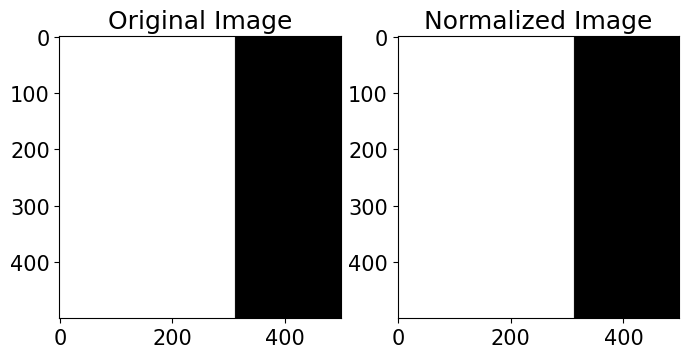

In [131]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Assuming you have the original and normalized images stored in original_image and normalized_image

# Load the original image
original_image_path = '../output/tiles/branch_line_coupler_0_250_0_5.png'
original_image = load_img(original_image_path, color_mode='grayscale', target_size=(500, 500))

# Convert the original image to an array
original_array = img_to_array(original_image)

# Normalize the pixel values
normalized_array = original_array / 255.0

# Display the original and normalized images side by side
plt.figure(figsize=(8, 4))

# # Original Image
# plt.subplot(1, 2, 1)
# plt.imshow(np.squeeze(original_array), cmap='gray')
# plt.title('Original Image')
# plt.axis('off')

# # Normalized Image
# plt.subplot(1, 2, 2)
# plt.imshow(np.squeeze(normalized_array), cmap='gray')
# plt.title('Normalized Image')
# plt.axis('off')

# plt.show()

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(original_array.reshape(500, 500), cmap='gray')  # Assuming it's a grayscale image
plt.title('Original Image')

# Plot the normalized image
plt.subplot(1, 2, 2)
plt.imshow(normalized_array.reshape(500, 500), cmap='gray')  # Assuming it's a grayscale image
plt.title('Normalized Image')

plt.show()


In [133]:
normalized_array[50]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [119]:
model_3 = create_model_3()
model_3.compile(optimizer=Adagrad(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
history = model_3.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size  
)

Epoch 1/20
58/58 [==============================] - 9s 146ms/step - loss: 1.1030 - accuracy: 0.4076 - val_loss: 1.1042 - val_accuracy: 0.3973
Epoch 2/20
58/58 [==============================] - 8s 141ms/step - loss: 1.0324 - accuracy: 0.5160 - val_loss: 1.0757 - val_accuracy: 0.4576
Epoch 3/20
58/58 [==============================] - 8s 139ms/step - loss: 0.9679 - accuracy: 0.5431 - val_loss: 1.0449 - val_accuracy: 0.4754
Epoch 4/20
58/58 [==============================] - 7s 124ms/step - loss: 0.8927 - accuracy: 0.5791 - val_loss: 1.0258 - val_accuracy: 0.4821
Epoch 5/20
58/58 [==============================] - 8s 140ms/step - loss: 0.8383 - accuracy: 0.6108 - val_loss: 1.0130 - val_accuracy: 0.4900
Epoch 6/20
58/58 [==============================] - 8s 137ms/step - loss: 0.7774 - accuracy: 0.6528 - val_loss: 1.0449 - val_accuracy: 0.5033
Epoch 7/20
58/58 [==============================] - 8s 143ms/step - loss: 0.7573 - accuracy: 0.6506 - val_loss: 1.0049 - val_accuracy: 0.4900
Epoch 

In [27]:
model.save('../output/model.h5')

In [112]:
plt.rcParams.update({'font.size': 15})
def showDetails_3(history, k):
    plt.figure(figsize=(8, 6))
    #plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.ylim([0,1.2])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    #plt.title(k)
    plt.show()

    plt.figure(figsize=(8,6))
    #plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.ylim([0.0,2])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    #plt.title(k)

    plt.show()

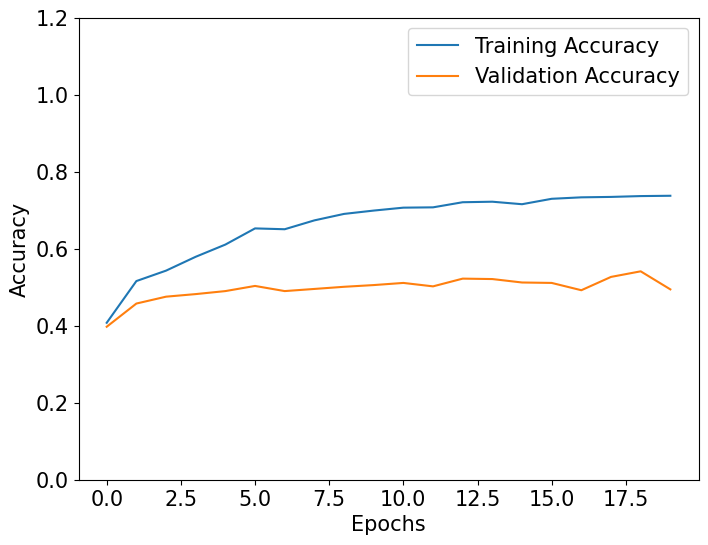

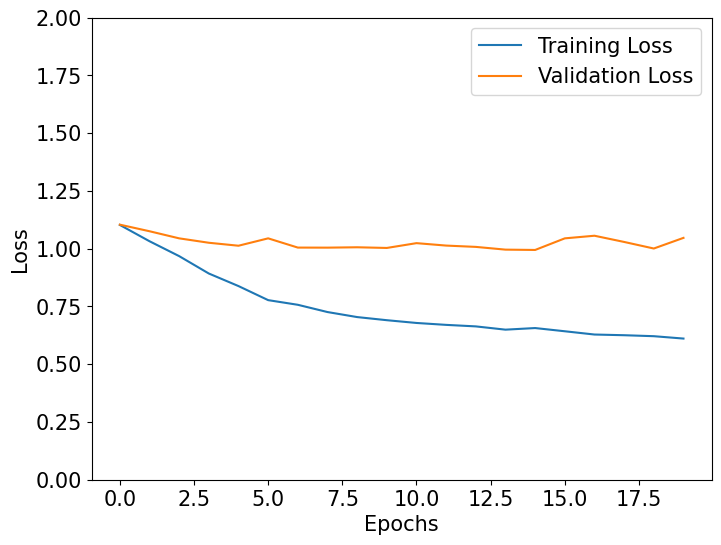

In [134]:
showDetails_3(history, 'Classification')

In [135]:
# Get predictions
Y_pred = model_3.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
labels = {0: 'Low', 1: 'Mid', 2: 'High'}
#labels = {0: 'Low', 1: 'High'}
#validation_labels = [labels[k] for k in val_generator.classes]
validation_labels = val_generator.classes
#print(y_pred)
y_true = val_generator.classes

15/15 [==============================] - 13s 902ms/step


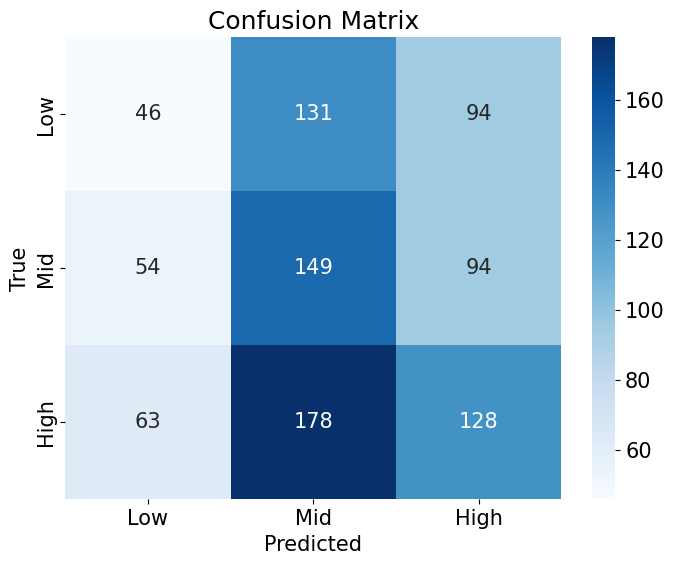

              precision    recall  f1-score   support

         Low       0.28      0.17      0.21       271
         Mid       0.33      0.50      0.39       297
        High       0.41      0.35      0.37       369

    accuracy                           0.34       937
   macro avg       0.34      0.34      0.33       937
weighted avg       0.34      0.34      0.33       937



In [136]:
# Plot confusion matrix with numerical values
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels.values(), yticklabels=labels.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=labels.values()))

In [35]:
import os
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.regularizers import l2
import cv2

In [29]:
base_dir = '../output/approach-2/'

In [30]:
# Create an ImageDataGenerator with rescaling
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [31]:
def apply_sobel(image_array):
    sobel_image_array = cv2.Sobel(image_array, cv2.CV_64F, 1, 0, ksize=3)
    return np.expand_dims(sobel_image_array, axis=-1)

In [32]:
def custom_data_generator(directory, subset, batch_size):
    generator = datagen.flow_from_directory(
        directory,
        target_size=(64, 64),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        subset=subset
    )

    for data_batch, labels_batch in generator:
        sobel_data_batch = np.array([apply_sobel(image) for image in data_batch])
        yield sobel_data_batch, labels_batch

In [33]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 1), kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(3, activation='softmax'))  # Assuming 3 classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [36]:
history = model.fit(
    custom_data_generator(base_dir, 'training', batch_size=32),
    steps_per_epoch=100,  # Adjust as needed
    epochs=10,
    validation_data=custom_data_generator(base_dir, 'validation', batch_size=32),
    validation_steps=50  # Adjust as needed
)

Found 3756 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 51s 513ms/step - loss: 0.9733 - accuracy: 0.5628 - val_loss: 1.1364 - val_accuracy: 0.4344
Epoch 2/10
100/100 [==============================] - 14s 142ms/step - loss: 0.7863 - accuracy: 0.6764 - val_loss: 1.2682 - val_accuracy: 0.4395
Epoch 3/10
100/100 [==============================] - 9s 88ms/step - loss: 0.7003 - accuracy: 0.7220 - val_loss: 1.3501 - val_accuracy: 0.4961
Epoch 4/10
100/100 [==============================] - 9s 88ms/step - loss: 0.6240 - accuracy: 0.7563 - val_loss: 1.3843 - val_accuracy: 0.4933
Epoch 5/10
100/100 [==============================] - 9s 87ms/step - loss: 0.6003 - accuracy: 0.7789 - val_loss: 1.4143 - val_accuracy: 0.4903
Epoch 6/10
100/100 [==============================] - 8s 85ms/step - loss: 0.5762 - accuracy: 0.7991 - val_loss: 1.5106 - val_accuracy: 0.4595
Epoch 7/10
100/100 [==============================] - 9s 87ms/step - loss: 0.5038 - accuracy: 0.

In [52]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [48]:
# Generate test data
test_generator = custom_data_generator(base_dir, 'validation', batch_size=32)
# Get the number of batches (steps) in the generator
test_steps = test_generator.n // test_generator.batch_size

# Account for the last batch if it's not a full batch
if test_generator.n % test_generator.batch_size != 0:
    test_steps += 1

# Get true labels
true_labels = []
for _ in range(test_steps):
    _, labels_batch = next(test_generator)
    true_labels.extend(np.argmax(labels_batch, axis=1))

NameError: name 'custom_data_generator' is not defined

In [49]:
predictions = model.predict_generator(test_generator, steps=test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

# Map classes to their names
class_names = {v: k for k, v in train_generator.class_indices.items()}

# Plot confusion matrix
plot_confusion_matrix(true_labels, predicted_labels, class_names.values())

# Evaluate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

NameError: name 'test_generator' is not defined

In [50]:
# Get predictions
val_generator = custom_data_generator(base_dir, 'validation', batch_size=32)


NameError: name 'custom_data_generator' is not defined

In [ ]:
list(val_generator)

In [47]:
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
labels = {0: 'Low', 1: 'Average', 2: 'High'}
#labels = {0: 'Low', 1: 'High'}
#validation_labels = [labels[k] for k in val_generator.classes]
validation_labels = val_generator.classes
#print(y_pred)
y_true = val_generator.classes

Found 937 images belonging to 3 classes.
   8551/Unknown - 462s 54ms/step

KeyboardInterrupt: 

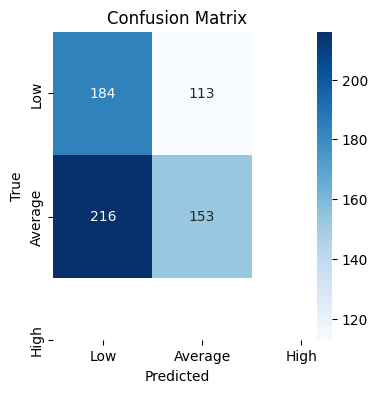

ValueError: Number of classes, 2, does not match size of target_names, 3. Try specifying the labels parameter

In [51]:
# Plot confusion matrix with numerical values
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels.values(), yticklabels=labels.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=labels.values()))

In [49]:
import os
import cv2
import numpy as np

# Function to apply Sobel filter to an image
def apply_sobel(image):
    # Your Sobel filter implementation
    # For example:
    sobel_image = cv2.Sobel(image, cv2.CV_64F, 1, 1, ksize=3)
    return sobel_image

# Source and destination directories
source_directory = '../output/approach-2/'
destination_directory = '../output/sobel/'

# Iterate through the source directory
for category_folder in os.listdir(source_directory):
    category_path = os.path.join(source_directory, category_folder)
    
    # Ensure it's a directory
    if os.path.isdir(category_path):
        # Create a subdirectory in the destination folder
        destination_category_path = os.path.join(destination_directory, category_folder)
        os.makedirs(destination_category_path, exist_ok=True)
        
        # Process each image in the category folder
        for filename in os.listdir(category_path):
            if filename.endswith(('.jpg', '.png')):  # Adjust based on your image format
                # Read the image
                image_path = os.path.join(category_path, filename)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                
                # Apply Sobel filter
                sobel_image = apply_sobel(image)
                
                # Save the processed image to the destination folder
                destination_path = os.path.join(destination_category_path, filename)
                cv2.imwrite(destination_path, sobel_image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


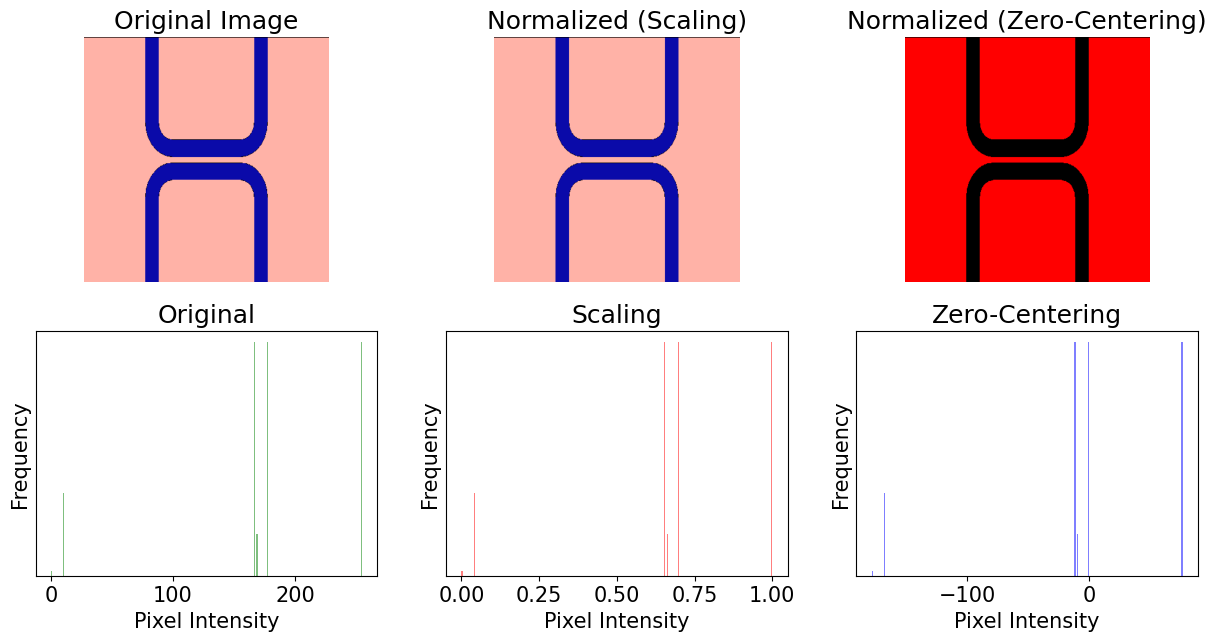

In [199]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array

# Load or create your image
img_path = '../output/3D_34.png'
img = image.load_img(img_path, target_size=(400, 400))  # Adjust target_size as needed

# Convert the image to a NumPy array
img_array = img_to_array(img)

# Type 1: Scaling to [0, 1]
normalized_image_1 = img_array / 255.0

# Type 2: Zero-centering
mean_intensity = np.mean(img_array)
normalized_image_2 = img_array - mean_intensity

# Plot the original and normalized images along with pixel intensity distribution
plt.figure(figsize=(15, 7))

# Original Image
plt.subplot(2, 3, 1)
plt.imshow(img_array.astype('uint8'))
plt.title('Original Image')
plt.axis('off')

# Pixel intensity distribution for Original Image
plt.subplot(2, 3, 4)
plt.hist(img_array.flatten(), bins=256, range=[0, 255], color='g', alpha=0.5)
plt.yticks([])
plt.title("Original")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

# Normalized Image (Type 1)
plt.subplot(2, 3, 2)
plt.imshow(normalized_image_1)
plt.title('Normalized (Scaling)')
plt.axis('off')

# Pixel intensity distribution for Type 1
plt.subplot(2, 3, 5)
plt.hist(normalized_image_1.flatten(), bins=256, range=[0, 1], color='r', alpha=0.5)
plt.yticks([])
plt.title("Scaling")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

# Normalized Image (Type 2)
plt.subplot(2, 3, 3)
plt.imshow(normalized_image_2)
plt.title('Normalized (Zero-Centering)')
plt.axis('off')

# Pixel intensity distribution for Type 2
plt.subplot(2, 3, 6)
plt.hist(normalized_image_2.flatten(), bins=256, color='b', alpha=0.5)
plt.title("Zero-Centering")
plt.yticks([])
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

plt.show()

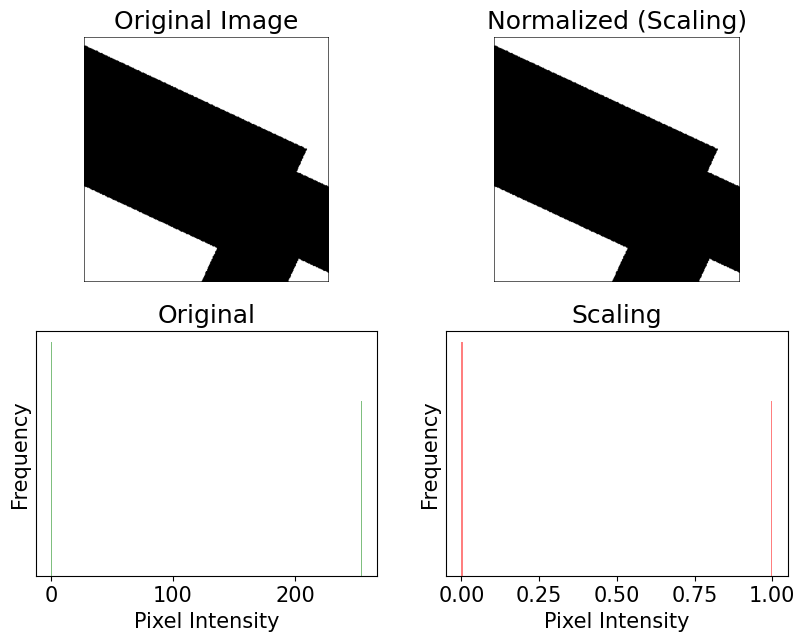

In [203]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array

# Load or create your image
img_path = '../output/tiles/branch_line_coupler_65_500_2_2.png'
img = image.load_img(img_path, target_size=(400, 400))  # Adjust target_size as needed

# Convert the image to a NumPy array
img_array = img_to_array(img)

# Type 1: Scaling to [0, 1]
normalized_image_1 = img_array / 255.0

# Type 2: Zero-centering
mean_intensity = np.mean(img_array)
normalized_image_2 = img_array - mean_intensity

# Function to add frame to an image
def add_frame(img, color='black', thickness=1):
    img_h, img_w, _ = img.shape
    framed_img = np.copy(img)
    framed_img[:thickness, :, :] = framed_img[-thickness:, :, :] = 0
    framed_img[:, :thickness, :] = framed_img[:, -thickness:, :] = 0
    return framed_img

# Plot the original and normalized images along with pixel intensity distribution
plt.figure(figsize=(15, 7))

# Original Image

plt.subplot(2, 3, 1)
framed_original = add_frame(img_array, color='black')
plt.imshow(framed_original.astype('uint8'))
plt.title('Original Image')
plt.axis('off')

# Pixel intensity distribution for Original Image
plt.subplot(2, 3, 4)
plt.hist(img_array.flatten(), bins=256, range=[0, 255], color='g', alpha=0.5)
plt.yticks([])
plt.title("Original")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

# Normalized Image (Type 1)
plt.subplot(2, 3, 2)
framed_normalized_image_1 = add_frame(normalized_image_1, color='black')
plt.imshow(framed_normalized_image_1)
plt.title('Normalized (Scaling)')
plt.axis('off')

# Pixel intensity distribution for Type 1
plt.subplot(2, 3, 5)
plt.hist(normalized_image_1.flatten(), bins=256, range=[0, 1], color='r', alpha=0.5)
plt.yticks([])
plt.title("Scaling")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

# # Normalized Image (Type 2)
# plt.subplot(2, 3, 3)
# framed_normalized_image_2 = add_frame(normalized_image_2, color='black')
# plt.imshow(framed_normalized_image_2)
# plt.title('Normalized (Zero-Centering)')
# plt.axis('off')

# # Pixel intensity distribution for Type 2
# plt.subplot(2, 3, 6)
# plt.hist(normalized_image_2.flatten(), bins=256, color='b', alpha=0.5)
# plt.title("Zero-Centering")
# plt.yticks([])
# plt.xlabel("Pixel Intensity")
# plt.ylabel("Frequency")

plt.show()

In [204]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Example feature data
feature_data = np.array([2.0, 5.0, 8.0, 11.0, 14.0])

# Min-Max Scaling
min_max_scaled = MinMaxScaler().fit_transform(feature_data.reshape(-1, 1)).flatten()

# Standardization
standardized = StandardScaler().fit_transform(feature_data.reshape(-1, 1)).flatten()

# Robust Scaling
robust_scaled = RobustScaler().fit_transform(feature_data.reshape(-1, 1)).flatten()

print("Original Feature Data:", feature_data)
print("Min-Max Scaled Data:", min_max_scaled)
print("Standardized Data:", standardized)
print("Robust Scaled Data:", robust_scaled)


Original Feature Data: [ 2.  5.  8. 11. 14.]
Min-Max Scaled Data: [0.   0.25 0.5  0.75 1.  ]
Standardized Data: [-1.41421356 -0.70710678  0.          0.70710678  1.41421356]
Robust Scaled Data: [-1.  -0.5  0.   0.5  1. ]
